## Incorrect disturbance (Need to rerun all)

In [52]:
import sys
sys.path.append('../../../src')
import os
import pandas
import random
import math
from itertools import product
from functools import reduce
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from pyomo.environ import value as pyoval
from energiapy.utils.scale_utils import scale_pyomo_set, scale_tuple, scale_list, scale_changer
import matplotlib.pyplot as plt
from matplotlib import rc
from typing import Union, Tuple, List
from pyomo.environ import ConcreteModel, Var, Constraint, NonNegativeReals, TerminationCondition
from pyomo.contrib.iis import write_iis
import time
import pickle
from energiapy.model.constraints.constraints import make_constraint, Cons
from energiapy.model.formulate import constraint_export, constraint_demand_penalty, constraint_demand_penalty_cost

import mpisppy.utils.sputils as sputils
from mpisppy.opt.ef import ExtensiveForm
import networkx as nx

In [2]:
_coms = 1

design_planning_horizons = 1
design_exec_scenarios = 4
design_scale_factor = 13*7

schedule_planning_horizons = 1
schedule_exec_scenarios = 52
schedule_time_intervals = 7

M = 1e3  # Big M

design_annualization_factor = 1/design_planning_horizons
schedule_annualization_factor = 1/schedule_planning_horizons

In [3]:
def create_list(n_total: int, n: int):
    return [1] * n + [0] * (n_total - n)

In [4]:
def sum_probabilities(d:dict):
    total_prob = 0

    def recursive_sum(current_dict:dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [5]:
def create_event_dict(n_total: int):
    default_list = [1] * n_total

    # If event names are same before '_'; they are considered mutually exclusive else the events are treated as independent
    event_dict = {
        'cap2_1': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_2': {'prob': 0.12, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 2)})},
        'cap2_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 3)})},
        # 'cap2_1': {'prob': 0.35, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_nd': {'prob': 0.65, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): default_list})},

        'cap4_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 1)})},
        'cap4_2': {'prob': 0.15, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_3': {'prob': 0.18, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 3)})},
        # 'cap4_2': {'prob': 0.38, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_nd': {'prob': 0.62, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): default_list})},

        'res6_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 1)})},
        'res6_2': {'prob': 0.16, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 2)})},
        'res6_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        # 'res6_3': {'prob': 0.36, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        'res6_nd': {'prob': 0.64, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): default_list})},

        'truck25_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 1)})},
        'truck25_2': {'prob': 0.2, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 2)})},
        'truck25_3': {'prob': 0.05, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 3)})},
        'truck25_nd': {'prob': 0.72, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): default_list})},

        'truck47_1': {'prob': 0.04, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 1)})},
        'truck47_2': {'prob': 0.085, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 2)})},
        'truck47_3': {'prob': 0.075, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 3)})},
        'truck47_nd': {'prob': 0.80, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): default_list})}
    }

    return event_dict

In [6]:
# Function to generate the scenario dictionary for n sets of events
def create_scenario_dict(event_dict):
    # Extract unique event prefixes (e.g., 'cap2', 'cap4', ...)
    event_prefixes = set(key.split('_')[0] for key in event_dict)

    # Group events by their prefixes
    grouped_events = {prefix: [key for key in event_dict if key.startswith(prefix)] for prefix in event_prefixes}

    # Create all possible combinations of events across the different groups
    event_combinations = list(product(*grouped_events.values()))

    scenario_dict = {}

    # Iterate over all event combinations
    for combination in event_combinations:
        # Construct the scenario key
        scenario_key = ' '.join(combination)

        # Calculate the probability of this scenario
        prob = 1
        combined_factor = None

        for event_key in combination:
            # Multiply probabilities
            prob *= event_dict[event_key]['prob']

            # Combine factors (assumes they are pandas DataFrames)
            if combined_factor is None:
                combined_factor = event_dict[event_key]['factor'].copy()
            else:
                combined_factor = combined_factor.add(event_dict[event_key]['factor'], fill_value=0)

        # Add to the scenario dictionary
        scenario_dict[scenario_key] = {'prob': prob, 'factor': combined_factor}

    return scenario_dict

In [7]:
def build_design_model(scen_df=pandas.DataFrame()):
    default_df = pandas.DataFrame(data=[1] * design_exec_scenarios)
    
    # Define temporal scales
    scales = TemporalScale(discretization_list=[design_planning_horizons, design_exec_scenarios])
    
    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=75*design_scale_factor, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
    
    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')
    
    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')
    
    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')
    
    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 150*design_scale_factor
    min_process_capacity = 0.01
    
    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.1/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')
    
    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 7')
    
    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
    
    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01/design_scale_factor, vopex=5, store_min=0.01, store_max= 100*design_scale_factor, prod_min=min_process_capacity, label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02, storage_capex=50/design_scale_factor)
    
    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 7')
    
    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})
    
    loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})
    
    loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})
    
    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4, com1_receive_loc6, com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})
    
    loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})
    
    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================
    
    truck_cap12 = 70 * design_scale_factor
    truck_cap13 = 30 * design_scale_factor
    truck_cap24 = 50 * design_scale_factor
    truck_cap25 = 30 * design_scale_factor
    truck_cap34 = 30 * design_scale_factor
    truck_cap45 = 100 * design_scale_factor
    truck_cap47 = 40 * design_scale_factor
    truck_cap64 = 50 * design_scale_factor
    truck_cap75 = 40 * design_scale_factor
    
    plane_cap15 = 50 * design_scale_factor
    plane_cap65 = 50 * design_scale_factor
    
    truck_capmin = 0.01
    plane_capmin = 0.01
    
    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3/design_scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3/design_scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2/design_scale_factor, vopex=0.02, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1/design_scale_factor, vopex=0.1, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4/design_scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4/design_scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15, label='Plane from location 1 to 5', capex=1/design_scale_factor, vopex=0.5,
                        trans_min=plane_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65, label='Plane from location 6 to 5', capex=1/design_scale_factor, vopex=0.5,
                        trans_min=plane_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [plane65], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, 150, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('truck12', 'com1_loc1_out')]] if ('truck12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('truck13', 'com1_loc1_out')]] if ('truck13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc5): {plane15: scen_df[[('plane15', 'com1_loc1_out')]] if ('plane15', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('truck24', 'com1_loc2_out')]] if ('truck24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('truck25', 'com1_loc2_out')]] if ('truck25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('truck34', 'com1_loc3_out')]] if ('truck34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('truck45', 'com1_loc4_out')]] if ('truck45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('truck47', 'com1_loc4_out')]] if ('truck47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('truck64', 'com1_loc6_out')]] if ('truck64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc6, loc5): {plane65: scen_df[[('plane65', 'com1_loc6_out')]] if ('plane65', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('truck75', 'com1_loc7_out')]] if ('truck75', 'com1_loc7_out') in scen_df else default_df},
                                                 })
    
    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================
    
    daily_demand = 100*design_scale_factor
    demand_penalty = 200
    
    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    
    scenario = Scenario(name=f'design scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=1, demand_scale_level=1, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Design Scenario', annualization_factor=design_annualization_factor)
    
    if scen_df.empty:
        # ======================================================================================================================
        # Declare problem
        # ======================================================================================================================

        problem_mincost = formulate(scenario=scenario,
                                    constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                                 Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                                 Constraints.NETWORK},
                                    demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

        scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
        # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
        # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
        
        problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
        
        def first_stage_cost_rule(instance):
            return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
                                                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
        
        problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)
        
        return scenario, problem_mincost
    else:
        return scenario

In [8]:
def build_design_smodel(scen_df=pandas.DataFrame()):
    scenario = build_design_model(scen_df)
    # ======================================================================================================================
    # Declare problem
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK},
                                demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

    scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)

    problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')

    def first_stage_cost_rule(instance):
        return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) +
                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))

    problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)

    return scenario, problem_mincost

In [9]:
def design_scenario_creator(scen_name, **kwargs):
    scen_dict = kwargs.get('scenario_dict')
    scen, model = build_design_smodel(scen_df=scen_dict[scen_name]['factor'])
    sputils.attach_root_node(model, model.first_stage_cost,
                             [model.X_P, model.Cap_P, model.X_S, model.Cap_S, model.X_F, model.Cap_F])
    model._mpisppy_probability = scen_dict[scen_name]['prob']
    return model

In [10]:
options = {"solver": "gurobi"}
solver_options = {
    'MIPGap': 0.005,
    'Heuristics': 0.20
}

In [11]:
# event_dict = create_event_dict(n_total=design_exec_scenarios)
# scenario_dict = create_scenario_dict(event_dict=event_dict)
# scenario_names = list(scenario_dict.keys())
# 
# with open('scenario_dict_HP.pkl', 'wb') as file:
#     pickle.dump(scenario_dict, file)
# 
# # print(*scenario_names, sep='\n')
# print(f"Sum of probabilities of all scenarios: {sum(scenario_dict[scen]['prob'] for scen in scenario_dict):.6f}")
# print(f'Number of considered scenarios: {len(scenario_names)}')

In [12]:
with open('scenario_dict_HP.pkl', 'rb') as file:
    load_scenario_dict = pickle.load(file)

load_scenario_names = list(load_scenario_dict.keys())

print(f"Sum of probabilities of all scenarios: {sum(load_scenario_dict[scen]['prob'] for scen in load_scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(load_scenario_names)}')

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 1024


In [13]:
nd_index = next((i for i, s in enumerate(list(load_scenario_dict.keys())) if all(word.endswith('_nd') for word in s.split())), -1)

In [14]:
PI_pkl_folder = r'PI_HP_pkl'
FD_pkl_folder = r'FD_HP_pkl'

In [15]:
# exCost_PI = 0
# results_PI = dict()
# scen_PI, model_PI = build_design_model()

In [16]:
# # Deterministic Scenarios for Perfect Information
# counter = 0
# PI_output_dict=dict()
# 
# for scen_name in load_scenario_names:
#     scen_PI = build_design_model(scen_df=load_scenario_dict[scen_name]['factor'])
#     counter+=1
#     # Delete process capacity factors, resource availability factors, transport capacity factors, penalty factors, and penalty cost factors
#     model_PI.del_component('constraint_nameplate_production_varying_capacity')
#     model_PI.del_component('constraint_resource_consumption_varying')
#     model_PI.del_component('constraint_export')
#     model_PI.del_component('constraint_demand_penalty')
#     model_PI.del_component('constraint_demand_penalty_cost')
# 
#     # Add the constraints back for this particular scenario
#     model_PI.constraint_nameplate_production_varying_capacity = make_constraint(instance=model_PI,
#         type_cons=Cons.X_LEQ_BY, variable_x='P', location_set=model_PI.locations, component_set=model_PI.processes_varying_capacity,
#         loc_comp_dict=scen_PI.location_process_dict, b_factor=scen_PI.capacity_factor,
#                                                                                 x_scale_level=scen_PI.scheduling_scale_level,
#                                                                                 b_scale_level=scen_PI.capacity_scale_level,
#                                                                                 y_scale_level=scen_PI.network_scale_level,
#                                                                                 variable_y='Cap_P',
#                                                                                 label='restricts production to varying nameplate capacity')
# 
#     model_PI.constraint_resource_consumption_varying = make_constraint(
#         instance=model_PI, type_cons=Cons.X_LEQ_B, variable_x='C', location_set=model_PI.locations,
#         component_set=model_PI.resources_varying_availability, b_max=scen_PI.cons_max,
#         loc_comp_dict=scen_PI.location_resource_dict, b_factor=scen_PI.availability_factor,
#         x_scale_level=scen_PI.scheduling_scale_level, b_scale_level=scen_PI.availability_scale_level,
#         label='restricts resource consumption to varying availablity')
# 
#     constraint_export(instance=model_PI, scheduling_scale_level=scen_PI.scheduling_scale_level,
#                       network_scale_level=scen_PI.network_scale_level,
#                       location_transport_resource_dict=scen_PI.location_transport_resource_dict,
#                       transport_capacity_factor=scen_PI.transport_capacity_factor,
#                       transport_capacity_scale_level=scen_PI.transport_capacity_scale_level)
# 
#     demand = scen_PI.demand
#     if isinstance(demand, dict):
#         if isinstance(list(demand.keys())[0], Location):
#             try:
#                 demand = {i.name: {
#                     j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
#             except:
#                 pass
# 
#     constraint_demand_penalty(instance=model_PI, demand_scale_level=scen_PI.demand_scale_level,
#                                       scheduling_scale_level=scen_PI.scheduling_scale_level, demand=demand,
#                                       demand_factor=scen_PI.demand_factor, location_resource_dict=scen_PI.location_resource_dict, sign='eq')
# 
#     constraint_demand_penalty_cost(instance=model_PI, demand_scale_level=scen_PI.demand_scale_level, demand_penalty_dict=scen_PI.demand_penalty, demand_penalty_factor=scen_PI.demand_penalty_factor)
# 
# 
#     results_PI[scen_name] = solve(scenario=scen_PI, instance=model_PI, solver='gurobi', name=scen_name,
#                        solver_options=solver_options)
# 
#     print(f'######################## Finished solving {scen_name} ({counter} of {len(load_scenario_names)}) ########################')
# 
#     model_vars = model_PI.component_map(ctype=Var)
#     vars_dict = {i: model_vars[i].extract_values() for i in model_vars.keys()}
#     obj_dict = {'objective': round(pyoval(model_PI.objective_cost_w_demand_penalty),4)}
# 
#     PI_output_dict[scen_name] = {**vars_dict, **obj_dict}
# 
#     with open(fr"{PI_pkl_folder}\{scen_name}_{len(load_scenario_names)}.pkl", 'wb') as file:
#         pickle.dump(PI_output_dict[scen_name], file)
# 
#     exCost_PI += pyoval(model_PI.objective_cost_w_demand_penalty) * load_scenario_dict[scen_name]['prob']

In [17]:
# print(f"Total Expected Cost considering perfect information: {exCost_PI:.4f}")

In [18]:
# for scen_name in load_scenario_names:
#     print(fr"Demand penalty cost of network for {scen_name}: {PI_output_dict[scen_name]['Demand_penalty_cost_network']}")

In [19]:
# with open(fr"{PI_pkl_folder}\exCost_{len(load_scenario_names)}_PI_HP.pkl", 'wb') as file:
#     pickle.dump(exCost_PI, file)

with open(fr"{PI_pkl_folder}\exCost_{len(load_scenario_names)}_PI_HP.pkl", 'rb') as file:
    exCost_PI_load = pickle.load(file)

In [20]:
exCost_PI_load

726981.9467877221

In [21]:
load_PI_dict = dict()
for file in os.listdir(PI_pkl_folder):
    if file.endswith('.pkl') and not file.endswith('_HP.pkl'):
        full_file_path = os.path.join(PI_pkl_folder, file)
        
        with open(full_file_path, 'rb') as f:
            load_PI_dict[file.removesuffix(f'_{len(load_scenario_names)}.pkl')] = pickle.load(f)
            
# len(PI_load_dict)

In [22]:
def find_common_substring(lst):
    
    # Split each string into substrings and create sets
    substring_sets = [set(item.split()) for item in lst]
    
    # Find the intersection of all sets to get common substrings
    common_substrings = reduce(lambda a, b: a & b, substring_sets)
    
    return common_substrings

In [23]:
def explore_dict(d, level=0):
    indent = "    " * level  # Indentation for better readability
    for key, value in d.items():
        print(f"{indent}Key: {key}, Type of value: {type(value)}")
        if isinstance(value, dict):  # Recursively explore dictionaries
            explore_dict(value, level + 1)

In [24]:
def filter_scenarios():
    # Initialize the result dictionary
    result = {}
    
    # Step 1: Iterate over the original data
    for scenario, data in load_PI_dict.items():
        x_val = round(data['Demand_penalty_network'][('com1_sold',0)], 4)
        obj_val = round(data['objective'] - data['Demand_penalty_network'][('com1_sold',0)], 4)
        
        # Step 2: Check if x_val is already a key in the result
        if x_val not in result:
            result[x_val] = {'count': 0, 'objectives': {}}
        
        # Increment the count for the x value
        result[x_val]['count'] += 1
        
        # Step 3: Check if obj_val is already a key under the 'objectives' for this x
        if obj_val not in result[x_val]['objectives']:
            result[x_val]['objectives'][obj_val] = {'scenarios': [], 'count': 0}
        
        # Add the scenario to the list and increment the count for the objective
        result[x_val]['objectives'][obj_val]['scenarios'].append(scenario)
        result[x_val]['objectives'][obj_val]['count'] += 1
    
    # Step 4: Sort the result by x values (in decreasing order) and objectives (in decreasing order)
    sorted_result = {
        x_val: {
            'count': result[x_val]['count'],
            'count_obj': len(result[x_val]['objectives']),
            'objectives': {
                obj_val: result[x_val]['objectives'][obj_val]
                for obj_val in sorted(result[x_val]['objectives'].keys(), reverse=True)
            }
        }
        for x_val in sorted(result.keys(), reverse=True)
    }
    
    return sorted_result

In [25]:
def pick_scenario_with_desired_probability(scenario_list, scenario_dict, min_choice:bool=True):
    # Filter scenarios in the list that are present in the dictionary
    valid_scenarios = [(s, scenario_dict[s]['prob']) for s in scenario_list if s in scenario_dict]

    # Find the maximum probability among valid scenarios
    if min_choice:
        des_prob = min(valid_scenarios, key=lambda x: x[1], default=(None, -1))[1]
    else:
        des_prob = max(valid_scenarios, key=lambda x: x[1], default=(None, -1))[1]

    # Collect scenarios with the maximum probability
    highest_prob_scenarios = [s for s, p in valid_scenarios if p == des_prob]

    return random.choice(highest_prob_scenarios) if highest_prob_scenarios else None

In [26]:
def pick_scenarios(sorted_dict, n):
    selected_scenarios = {}
    total_selected = 0

    # Iterate over sorted x values
    for x_val, x_data in sorted_dict.items():
        if total_selected >= n:
            break  # Stop if we have selected enough scenarios

        # Iterate over sorted objective values within each x
        for obj_val, obj_data in x_data['objectives'].items():
            if total_selected >= n:
                break  # Stop if we have selected enough scenarios

            # Get the list of scenarios for the current objective
            scenarios_to_choose = obj_data['scenarios']

            # Choose the scenario with the highest probability using the previous logic
            chosen_scenario = pick_scenario_with_desired_probability(scenarios_to_choose, load_scenario_dict)

            # Add the selected scenario to the result
            if chosen_scenario:
                if x_val not in selected_scenarios:
                    selected_scenarios[x_val] = {}

                if obj_val not in selected_scenarios[x_val]:
                    selected_scenarios[x_val][obj_val] = {}

                selected_scenarios[x_val][obj_val][chosen_scenario] = {
                    'prob': load_scenario_dict[chosen_scenario]['prob'],
                    'factor': load_scenario_dict[chosen_scenario]['factor'].copy()
                }
                total_selected += 1

            if total_selected >= n:
                break  # Stop if we have selected enough scenarios

    return selected_scenarios


In [27]:
def sum_probabilities(d):
    total_prob = 0
    
    def recursive_sum(current_dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [28]:
# sorted_result = filter_scenarios()
# 
# with open(fr"sorted_result_{len(load_scenario_names)}_HP.pkl", 'wb') as file:
#     pickle.dump(sorted_result, file)

In [29]:
with open(fr"sorted_result_{len(load_scenario_names)}_HP.pkl", 'rb') as file:
    load_sorted_result = pickle.load(file)

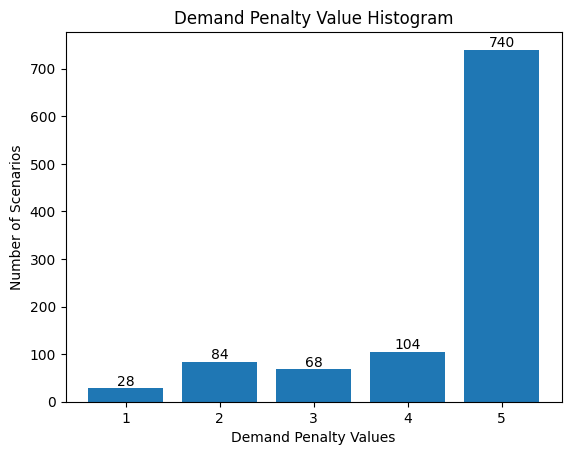

In [30]:
# Example data
n = len(list(load_sorted_result.keys()))
list1 = [i for i in range(1,n+1)]  # X-axis labels
list2 = [load_sorted_result[key]['count'] for key, data in load_sorted_result.items()]

# Create a bar chart
plt.bar(list1, list2)

# Add labels and title
plt.xlabel('Demand Penalty Values')
plt.ylabel('Number of Scenarios')
plt.title('Demand Penalty Value Histogram')

for i, value in enumerate(list2):
    plt.text(i+1, value, str(value), ha='center', va='bottom')

# Rotate the x-axis labels if they are too long or overlapping
plt.xticks()

# Show the plot
plt.show()

In [31]:
list(load_sorted_result.keys())

[9100.0, 6825.0, 4550.0, 2275.0, 0.0]

In [32]:
sum(data['count_obj'] for key, data in load_sorted_result.items())

266

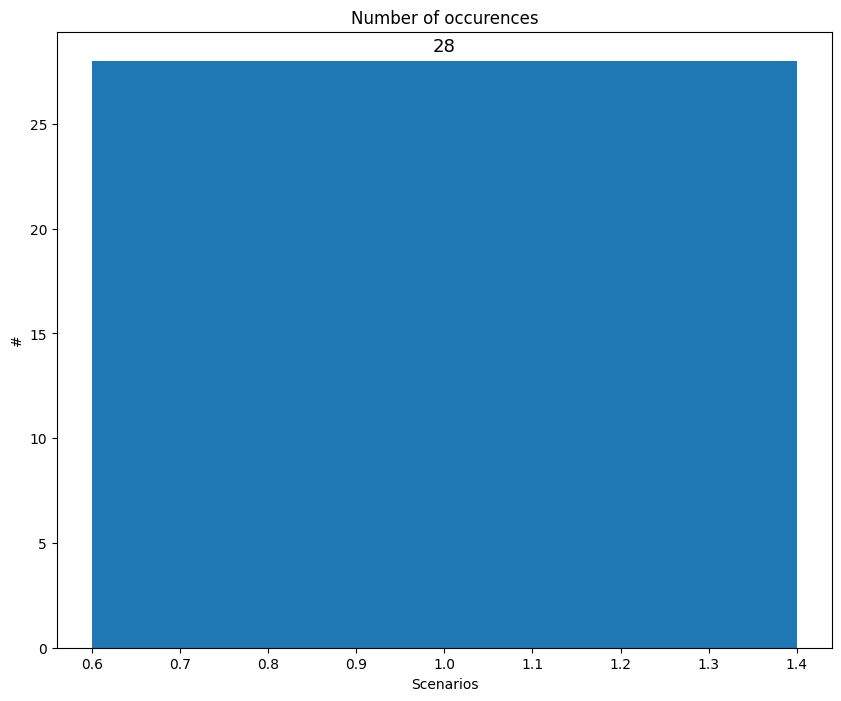

In [33]:
penalty_key = list(load_sorted_result.keys())[0]
n = min(load_sorted_result[penalty_key]['count_obj'], 10)
obj_keys = [list(load_sorted_result[penalty_key]['objectives'].keys())[i] for i in range(n)]
list1 = [i for i in range(1,n+1)]  # X-axis labels
list2 = [load_sorted_result[penalty_key]['objectives'][obj_keys[i]]['count'] for i in range(n)]

plt.figure(figsize=(10,8))

# Create a bar chart
plt.bar(list1, list2)

# Add labels and title
plt.xlabel('Scenarios')
plt.ylabel('#')
plt.title('Number of occurences')

for i, value in enumerate(list2):
    plt.text(i+1, value+0.25, str(value), ha='center', va='bottom', fontsize=13)

# Rotate the x-axis labels if they are too long or overlapping
# plt.xticks(rotation=45)

# Show the plot
plt.show()

In [34]:
for pen_key in load_sorted_result:
    print(fr"Number of distinct objectives for demand penalty of {pen_key}: {load_sorted_result[pen_key]['count_obj']}")

Number of distinct objectives for demand penalty of 9100.0: 1
Number of distinct objectives for demand penalty of 6825.0: 9
Number of distinct objectives for demand penalty of 4550.0: 21
Number of distinct objectives for demand penalty of 2275.0: 44
Number of distinct objectives for demand penalty of 0.0: 191


In [35]:
find_common_substring(load_sorted_result[penalty_key]['objectives'][obj_keys[0]]['scenarios'])

{'cap4_1', 'res6_1'}

In [36]:
commons_dict = dict() # Keys are of structure (penalty_key, objective_key)
for pen_key in load_sorted_result:
    for obj_key in load_sorted_result[pen_key]['objectives']:
        commons_dict[(pen_key, obj_key)] = list(find_common_substring(load_sorted_result[pen_key]['objectives'][obj_key]['scenarios']))
commons_dict

{(9100.0, 3077124.2375): ['cap4_1', 'res6_1'],
 (6825.0, 2611722.9375): ['cap4_1', 'res6_1'],
 (6825.0, 2504221.9): ['truck47_1', 'cap2_1', 'cap4_2', 'res6_1'],
 (6825.0, 2503396.95): ['cap2_1', 'cap4_2', 'res6_1'],
 (6825.0, 2328468.1002): ['truck25_1', 'truck47_1', 'res6_1', 'cap4_2'],
 (6825.0, 2328468.1): ['cap2_2', 'truck47_1', 'cap4_2', 'res6_1', 'truck25_1'],
 (6825.0, 2323926.1): ['res6_1', 'truck25_1', 'cap4_2'],
 (6825.0, 2284078.8015): ['cap2_nd', 'truck47_1', 'res6_1', 'cap4_2'],
 (6825.0, 2284078.8): ['truck47_1', 'res6_1', 'cap4_2'],
 (6825.0, 2281912.05): ['res6_1', 'cap4_2'],
 (4550.0, 2146321.6375): ['res6_1', 'cap4_1', 'cap2_3', 'truck25_nd'],
 (4550.0, 2066629.3024): ['truck47_1', 'cap2_1', 'cap4_3', 'res6_1'],
 (4550.0, 2064904.825): ['truck47_2', 'cap2_1', 'cap4_3', 'res6_1'],
 (4550.0, 2060837.6): ['cap2_1', 'cap4_3', 'res6_1'],
 (4550.0, 1889532.3833): ['cap2_2',
  'truck47_1',
  'res6_1',
  'truck25_1',
  'cap4_3'],
 (4550.0, 1885707.65): ['cap2_2',
  'truck47_2

## RUN FROM HERE

In [37]:
scenarios_to_select = 10
random.seed(2)
selected_scenarios = pick_scenarios(load_sorted_result, scenarios_to_select)

In [38]:
selected_scenarios

{9100.0: {3077124.2375: {'truck47_1 truck25_1 cap2_1 res6_1 cap4_1': {'prob': 1.0799999999999999e-07,
    'factor':           loc2         loc4     loc6       truck25       truck47
      com1_process com1_process com1_pur com1_loc2_out com1_loc4_out
    0          1.0          1.0      1.0           1.0           1.0
    1          0.0          0.0      0.0           0.0           0.0
    2          0.0          0.0      0.0           0.0           0.0
    3          0.0          0.0      0.0           0.0           0.0}}},
 6825.0: {2611722.9375: {'truck47_1 truck25_3 cap2_2 res6_1 cap4_1': {'prob': 3.6e-07,
    'factor':           loc2         loc4     loc6       truck25       truck47
      com1_process com1_process com1_pur com1_loc2_out com1_loc4_out
    0          1.0          1.0      1.0           1.0           1.0
    1          1.0          0.0      0.0           1.0           0.0
    2          0.0          0.0      0.0           0.0           0.0
    3          0.0          

In [39]:
# norm_factor = sum_probabilities(selected_scenarios)+load_scenario_dict[list(load_scenario_dict.keys())[nd_index]]['prob']
norm_factor = sum_probabilities(selected_scenarios)
selected_scenario_dict = {
    k: {
        'prob': scenario_data['prob'] / norm_factor,
        'factor': scenario_data['factor'].copy()
    }
    for i, inner_dict in selected_scenarios.items()
    for j, sub_dict in inner_dict.items()
    for k, scenario_data in sub_dict.items()
}

# selected_scenario_dict[list(load_scenario_dict.keys())[nd_index]] = {'prob': load_scenario_dict[list(load_scenario_dict.keys())[nd_index]]['prob']/norm_factor,
#                                                                                          'factor': load_scenario_dict[list(load_scenario_dict.keys())[nd_index]]['factor'].copy()}

selected_scenario_names = list(selected_scenario_dict.keys())
print(f'Number of scenarios considered: {len(selected_scenario_names)}')
prob_select = sum_probabilities(selected_scenario_dict)
print(f'Sum of probabilities of selected scenarios: {prob_select:.6f}')

Number of scenarios considered: 10
Sum of probabilities of selected scenarios: 1.000000


In [40]:
selected_scenario_dict

{'truck47_1 truck25_1 cap2_1 res6_1 cap4_1': {'prob': 0.008221993833504623,
  'factor':           loc2         loc4     loc6       truck25       truck47
    com1_process com1_process com1_pur com1_loc2_out com1_loc4_out
  0          1.0          1.0      1.0           1.0           1.0
  1          0.0          0.0      0.0           0.0           0.0
  2          0.0          0.0      0.0           0.0           0.0
  3          0.0          0.0      0.0           0.0           0.0},
 'truck47_1 truck25_3 cap2_2 res6_1 cap4_1': {'prob': 0.02740664611168208,
  'factor':           loc2         loc4     loc6       truck25       truck47
    com1_process com1_process com1_pur com1_loc2_out com1_loc4_out
  0          1.0          1.0      1.0           1.0           1.0
  1          1.0          0.0      0.0           1.0           0.0
  2          0.0          0.0      0.0           0.0           0.0
  3          0.0          0.0      0.0           0.0           0.0},
 'truck47_1 truck25_1

## Stochastic Problem

In [41]:
# options = {"solver": "gurobi"}
scenario_creator_kwargs = {'scenario_dict': selected_scenario_dict}

In [42]:
start_time = time.time()
ef_UI = ExtensiveForm(options, selected_scenario_names, design_scenario_creator, scenario_creator_kwargs=scenario_creator_kwargs)
results = ef_UI.solve_extensive_form(solver_options=solver_options)
end_time = time.time()

[    5.91] Initializing SPBase
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand pe

In [43]:
# exCost_UI = ef_UI.get_objective_value()
# 
# with open(fr"{FD_pkl_folder}\{len(selected_scenario_names)}\exCost_{len(selected_scenario_names)}_UI_HP.pkl", 'wb') as file:
#     pickle.dump(exCost_UI, file)
    
with open(fr"{FD_pkl_folder}\{len(selected_scenario_names)}\exCost_{len(selected_scenario_names)}_UI_HP.pkl", 'rb') as file:
    load_exCost_UI = pickle.load(file)

In [44]:
# ssoln_dict = ef_UI.get_root_solution()
# with open(fr"{FD_pkl_folder}\{len(selected_scenario_names)}\ssoln_{len(selected_scenario_names)}_UI_HP.pkl", 'wb') as file:
#     pickle.dump(ssoln_dict, file)
    
with open(fr"{FD_pkl_folder}\{len(selected_scenario_names)}\ssoln_{len(selected_scenario_names)}_UI_HP.pkl", 'rb') as file:
    load_ssoln_dict = pickle.load(file)

load_ssoln_dict = {key: round(value, 4) for key, value in load_ssoln_dict.items()}

In [45]:
print(*[(key, value) for key, value in load_ssoln_dict.items() if value], sep='\n')

('X_P[loc1,com1_loc1_send,0]', 1.0)
('X_P[loc1,com1_process,0]', 1.0)
('X_P[loc1,procure com1,0]', 1.0)
('X_P[loc2,com1_loc2_send,0]', 1.0)
('X_P[loc2,com1_process,0]', 1.0)
('X_P[loc2,com1_receive_loc1,0]', 1.0)
('X_P[loc3,com1_loc3_send,0]', 1.0)
('X_P[loc3,com1_process,0]', 1.0)
('X_P[loc3,com1_receive_loc1,0]', 1.0)
('X_P[loc4,com1_loc4_send,0]', 1.0)
('X_P[loc4,com1_process,0]', 1.0)
('X_P[loc4,com1_receive_loc2,0]', 1.0)
('X_P[loc4,com1_receive_loc3,0]', 1.0)
('X_P[loc4,com1_receive_loc6,0]', 1.0)
('X_P[loc5,com1_process,0]', 1.0)
('X_P[loc5,com1_receive_loc1,0]', 1.0)
('X_P[loc5,com1_receive_loc2,0]', 1.0)
('X_P[loc5,com1_receive_loc4,0]', 1.0)
('X_P[loc5,com1_receive_loc6,0]', 1.0)
('X_P[loc5,com1_receive_loc7,0]', 1.0)
('X_P[loc5,com1_store,0]', 1.0)
('X_P[loc5,com1_store_discharge,0]', 1.0)
('X_P[loc5,sell com1,0]', 1.0)
('X_P[loc6,com1_loc6_send,0]', 1.0)
('X_P[loc6,com1_process,0]', 1.0)
('X_P[loc6,com1_store,0]', 1.0)
('X_P[loc6,com1_store_discharge,0]', 1.0)
('X_P[loc6,pr

In [46]:
load_exCost_UI

2336777.9323441237

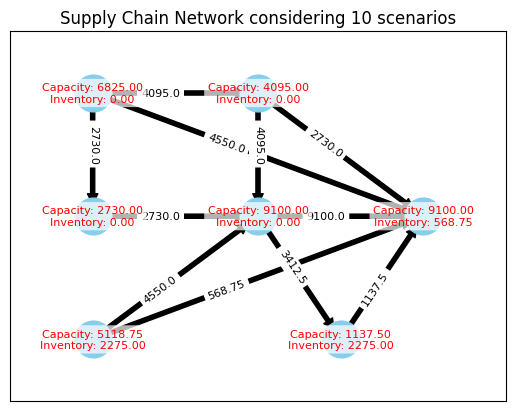

In [47]:
G = nx.DiGraph()

ssoln_dict = load_ssoln_dict
nodes = {
'Location 1': {
    'Capacity': ssoln_dict['Cap_P[loc1,com1_process,0]'] if 'Cap_P[loc1,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc1,com1_store_com1_in_stored,0]'] if 'Cap_S[loc1,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 2': {
    'Capacity': ssoln_dict['Cap_P[loc2,com1_process,0]'] if 'Cap_P[loc2,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc2,com1_store_com1_in_stored,0]'] if 'Cap_S[loc2,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 3': {
    'Capacity': ssoln_dict['Cap_P[loc3,com1_process,0]'] if 'Cap_P[loc3,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc3,com1_store_com1_in_stored,0]'] if 'Cap_S[loc3,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 4': {
    'Capacity': ssoln_dict['Cap_P[loc4,com1_process,0]'] if 'Cap_P[loc4,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc4,com1_store_com1_in_stored,0]'] if 'Cap_S[loc4,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 5': {
    'Capacity': ssoln_dict['Cap_P[loc5,com1_process,0]'] if 'Cap_P[loc5,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc5,com1_store_com1_in_stored,0]'] if 'Cap_S[loc5,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 6': {
    'Capacity': ssoln_dict['Cap_P[loc6,com1_process,0]'] if 'Cap_P[loc6,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc6,com1_store_com1_in_stored,0]'] if 'Cap_S[loc6,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
'Location 7': {
    'Capacity': ssoln_dict['Cap_P[loc7,com1_process,0]'] if 'Cap_P[loc7,com1_process,0]' in ssoln_dict.keys() else 0,
    'Inventory': ssoln_dict['Cap_S[loc7,com1_store_com1_in_stored,0]'] if 'Cap_S[loc7,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
},
}

# Add nodes to the graph
G.add_nodes_from(nodes.keys())

# Define edges (connections between nodes)
edges = [
    ('Location 1', 'Location 2', {'weight': ssoln_dict['Cap_F[loc1,loc2,truck12,0]'] if 'Cap_F[loc1,loc2,truck12,0]' in ssoln_dict.keys() else 0}),
    ('Location 1', 'Location 3', {'weight': ssoln_dict['Cap_F[loc1,loc3,truck13,0]'] if 'Cap_F[loc1,loc3,truck13,0]' in ssoln_dict.keys() else 0}),
    ('Location 1', 'Location 5', {'weight': ssoln_dict['Cap_F[loc1,loc5,plane15,0]'] if 'Cap_F[loc1,loc5,plane15,0]' in ssoln_dict.keys() else 0}),
    ('Location 2', 'Location 4', {'weight': ssoln_dict['Cap_F[loc2,loc4,truck24,0]'] if 'Cap_F[loc2,loc4,truck24,0]' in ssoln_dict.keys() else 0}),
    ('Location 2', 'Location 5', {'weight': ssoln_dict['Cap_F[loc2,loc5,truck25,0]'] if 'Cap_F[loc2,loc5,truck25,0]' in ssoln_dict.keys() else 0}),
    ('Location 3', 'Location 4', {'weight': ssoln_dict['Cap_F[loc3,loc4,truck34,0]'] if 'Cap_F[loc3,loc4,truck34,0]' in ssoln_dict.keys() else 0}),
    ('Location 4', 'Location 5', {'weight': ssoln_dict['Cap_F[loc4,loc5,truck45,0]'] if 'Cap_F[loc4,loc5,truck45,0]' in ssoln_dict.keys() else 0}),
    ('Location 4', 'Location 7', {'weight': ssoln_dict['Cap_F[loc4,loc7,truck47,0]'] if 'Cap_F[loc4,loc7,truck47,0]' in ssoln_dict.keys() else 0}),
    ('Location 6', 'Location 4', {'weight': ssoln_dict['Cap_F[loc6,loc4,truck64,0]'] if 'Cap_F[loc6,loc4,truck64,0]' in ssoln_dict.keys() else 0}),
    ('Location 6', 'Location 5', {'weight': ssoln_dict['Cap_F[loc6,loc5,plane65,0]'] if 'Cap_F[loc6,loc5,plane65,0]' in ssoln_dict.keys() else 0}),
    ('Location 7', 'Location 5', {'weight': ssoln_dict['Cap_F[loc7,loc5,truck75,0]'] if 'Cap_F[loc7,loc5,truck75,0]' in ssoln_dict.keys() else 0}),
]

# Add edges to the graph
G.add_edges_from(edges)

# Define fixed positions for nodes
fixed_positions = {
    'Location 1': (-2, 2),
    'Location 2': (0, 2),
    'Location 3': (-2, 0),
    'Location 4': (0, 0),
    'Location 5': (2, 0),
    'Location 6': (-2, -2),
    'Location 7': (1, -2)
}

# Create custom labels combining multiple pieces of information
node_labels = {node: f"Capacity: {data['Capacity']:.2f}\nInventory: {data['Inventory']:.2f}" for node, data in nodes.items()}

# Draw nodes and edges with fixed positions
nx.draw_networkx_nodes(G, fixed_positions, node_color='skyblue', node_size=700)
nx.draw_networkx_edges(G, fixed_positions, edgelist=edges, arrowstyle='simple', arrowsize=15)
nx.draw_networkx_labels(G, fixed_positions, labels=node_labels, font_size=8, font_color='red', bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.3"))

# Draw edge labels (optional)
edge_labels = {(u, v): round(d['weight'],3) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, fixed_positions, edge_labels=edge_labels, label_pos=0.4, font_size=8)

# Expand plot limits to prevent cutoff
x_values, y_values = zip(*fixed_positions.values())
plt.xlim(min(x_values) - 1, max(x_values) + 1)
plt.ylim(min(y_values) - 1, max(y_values) + 1)

# Show the plot
plt.title(f"Supply Chain Network considering {len(selected_scenario_names)} scenarios")
# plt.figure(figsize=(16,12))
plt.show()  

In [53]:
results.solver.termination_condition == TerminationCondition.infeasible

False

## DESIGN COMPLETE

In [90]:
def build_schedule_model(start_time:tuple, end_time:tuple, scen_df=pandas.DataFrame()):
    default_exec_df = pandas.DataFrame(data=[1] * schedule_exec_scenarios)
    default_sced_df = pandas.DataFrame(data=[1]*(schedule_exec_scenarios*schedule_time_intervals))
    scale_factor = 1
    
    # Define temporal scales
    scales = TemporalScale(discretization_list=[schedule_planning_horizons, schedule_exec_scenarios, schedule_time_intervals], start_zero=start_time, end_zero=end_time)
    
    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=75*scale_factor, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
    
    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')
    
    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')
    
    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system', varying=[VaryingResource.DETERMINISTIC_DEMAND])
    
    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 150*scale_factor
    min_process_capacity = 0.01
    
    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')
    
    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 7')
    
    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
    
    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01/scale_factor, vopex=5, store_min=0.01, store_max= 100*scale_factor, prod_min=min_process_capacity, label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02, storage_capex=50/scale_factor)
    
    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01/scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 7')
    
    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_exec_df})
    
    loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_exec_df})
    
    loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)
    
    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_exec_df})
    
    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4, com1_receive_loc6, com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, demand_factor={com1_sold: scen_df[[('loc5', 'com1_sold')]] if ('loc5', 'com1_sold') in scen_df else default_sced_df}, demand_penalty_factor={com1_sold: scen_df[[('loc5', 'penalty', 'com1_sold')]] if ('loc5', 'penalty', 'com1_sold') in scen_df else default_sced_df}, demand_penalty_scale_level=2)
    
    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_exec_df})
    
    loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_exec_df})
    
    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================
    
    truck_cap12 = 70 * scale_factor
    truck_cap13 = 30 * scale_factor
    truck_cap24 = 50 * scale_factor
    truck_cap25 = 30 * scale_factor
    truck_cap34 = 30 * scale_factor
    truck_cap45 = 100 * scale_factor
    truck_cap47 = 40 * scale_factor
    truck_cap64 = 50 * scale_factor
    truck_cap75 = 40 * scale_factor
    
    plane_cap15 = 50 * scale_factor
    plane_cap65 = 50 * scale_factor
    
    truck_capmin = 0.01
    plane_capmin = 0.01
    
    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3/scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3/scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2/scale_factor, vopex=0.02, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1/scale_factor, vopex=0.1, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4/scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4/scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15, label='Plane from location 1 to 5', capex=1/scale_factor, vopex=0.5,
                        trans_min=plane_capmin, speed=100)
    
    plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65, label='Plane from location 6 to 5', capex=1/scale_factor, vopex=0.5,
                        trans_min=plane_capmin, speed=100)
    
    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [plane65], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, 150, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('trans12', 'com1_loc1_out')]] if ('trans12', 'com1_loc1_out') in scen_df else default_exec_df},
                                                 (loc1, loc3): {truck13: scen_df[[('trans13', 'com1_loc1_out')]] if ('trans13', 'com1_loc1_out') in scen_df else default_exec_df},
                                                 (loc2, loc4): {truck24: scen_df[[('trans24', 'com1_loc2_out')]] if ('trans24', 'com1_loc2_out') in scen_df else default_exec_df},
                                                 (loc2, loc5): {truck25: scen_df[[('trans25', 'com1_loc2_out')]] if ('trans25', 'com1_loc2_out') in scen_df else default_exec_df},
                                                 (loc3, loc4): {truck34: scen_df[[('trans34', 'com1_loc3_out')]] if ('trans34', 'com1_loc3_out') in scen_df else default_exec_df},
                                                 (loc4, loc5): {truck45: scen_df[[('trans45', 'com1_loc4_out')]] if ('trans45', 'com1_loc4_out') in scen_df else default_exec_df},
                                                 (loc4, loc7): {truck47: scen_df[[('trans47', 'com1_loc4_out')]] if ('trans47', 'com1_loc4_out') in scen_df else default_exec_df},
                                                 (loc6, loc4): {truck64: scen_df[[('trans64', 'com1_loc6_out')]] if ('trans64', 'com1_loc6_out') in scen_df else default_exec_df},
                                                 (loc7, loc5): {truck75: scen_df[[('trans75', 'com1_loc7_out')]] if ('trans75', 'com1_loc7_out') in scen_df else default_exec_df},
                                                 })
    
    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================
    
    daily_demand = 100*scale_factor
    demand_penalty = 200
    
    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    
    scenario = Scenario(name=f'schedule scenario', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, demand_penalty_scale_level=2, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Schedule Scenario', annualization_factor=1)
    
    # ======================================================================================================================
    # Declare model
    # ======================================================================================================================
    
    problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND, Constraints.NETWORK}, demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
    
    return scenario, problem_mincost

In [49]:
def fix_design_variables(model2fix: ConcreteModel, design_model: ConcreteModel):
    model = getattr(design_model.ef, [i[0] for i in design_model.scenarios()][0])

    def fix(var1, var2):
        for i in list(var1.keys()):
            if var1[i].value is None:
                continue
            elif ('X_P' in var1.name) or ('X_S' in var1.name) or ('X_F' in var1.name):
                var2[i].fix(var1[i].value)
            elif ('Cap_P' in var1.name) or ('Cap_S' in var1.name) or ('Cap_F' in var1.name):
                var2[i].fix(round(var1[i].value/design_scale_factor, 4))

    fix(model.X_P, model2fix.X_P)
    fix(model.Cap_P, model2fix.Cap_P)
    fix(model.X_S, model2fix.X_S)
    fix(model.Cap_S, model2fix.Cap_S)
    fix(model.X_F, model2fix.X_F)
    fix(model.Cap_F, model2fix.Cap_F)

In [50]:
def fix_schedule_variables(model2fix: ConcreteModel, current_time_idx:tuple, initial_dict: dict,time_scales:TemporalScale, final_fix:bool=False):
    states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'Capex_process', 'Capex_storage', 'Inv_cost', 'X_F', 'Cap_F', 'Exp', 'Capex_transport', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']
    
    model2fix_vars = {v.name: v for v in model2fix.component_objects(Var) if v.name in states}
    if final_fix:
        for name, var in model2fix_vars.items():
            for key in var:
                if not var[key].fixed:
                    var[key].fixed = True
    else:
        for name, var in model2fix_vars.items():
            var_key_list = [k for k in var.keys()]
            updated_key_list = list()
            
            if var_key_list and var_key_list!= [None]:
                if isinstance(var_key_list[0], int):
                    # updated_key_list = [i for i in var_key_list if tuple((i,)) < current_time_idx[:network_scale_level+1]] 
                    continue
                elif isinstance(var_key_list[0], tuple) and ('location' not in name and 'network' not in name):
                    num_integers = sum(1 for elem in var_key_list[0] if isinstance(elem, int))
                    scale_length = min(len(time_scales.scale), num_integers)                
                    updated_key_list = [k for k in var.keys()
                                        if tuple(k[-scale_length:]) < current_time_idx[:scale_length] or (tuple(k[-scale_length:]) == current_time_idx[:scale_length] and current_time_idx[1:]!=(0,)*(len(current_time_idx)-1) and tuple(k[-scale_length:]) != current_time_idx)]
                    
                for key in updated_key_list:
                    if key in initial_dict[name] and initial_dict[name][key] is not None:
                        if not var[key].fixed:
                            var[key].fix(initial_dict[name][key])

    print(f"Variables fixed for time {current_time_idx}")

In [51]:
def print_fixed_variables(instance:ConcreteModel):    
    for v in instance.component_objects(Var):
        for index in v:
            if v[index].fixed:
                print(f"{v.name}[{index}]: {v[index].value}")

def get_fixed_variables(instance:ConcreteModel):
    return {v.name: {index: v[index].value for index in v if v[index].fixed} for v in instance.component_objects(Var)}

In [52]:
model_record = dict()
scenario_record = dict()
results_record = dict()

In [53]:
scheduling_scales = TemporalScale(discretization_list=[1, schedule_exec_scenarios, schedule_time_intervals])
scale_iter_list = scheduling_scales.scale_iter(scale_level=len(scheduling_scales.scale)-1)

In [54]:
def supply_chain_controller(time_ind:List, start_at:Union[int, Tuple]=0, end_at:Union[int, Tuple]=None, initialize_dict:dict=None, p_horizon:int=1, c_horizon:int=1, lookback:int=0, design_model:ConcreteModel=None):
    
    end_at = end_at or len(time_ind)-1
    
    close_loop_results = dict()
    if c_horizon > p_horizon:
        raise ValueError('c_horizon must be less than or equal to p_horizon')
    
    if isinstance(start_at, Tuple):
        if start_at not in time_ind:
            raise ValueError('Incorrect start time value')
        start_idx = time_ind.index(start_at)
    else:
        start_idx = start_at
        
    if isinstance(end_at, Tuple):
        if end_at not in time_ind:
            raise ValueError('Incorrect end time value')
        end_idx = time_ind.index(end_at)
    else:
        end_idx = end_at
    
    if end_idx < start_idx:
        raise ValueError('Incorrect start and end time values')

    # print(f"Starting Index: {start_idx}; Starting Time: {start_time}")
    # print(f"Ending Index: {end_idx}; Ending Time: {end_time}")
    
    
    for t in range(start_idx, end_idx+1, c_horizon):
        start_time = max(0, t-lookback)
        end_time = min(t+p_horizon, end_idx)
        scenario, model = build_schedule_model(start_time=time_ind[start_time], end_time=time_ind[end_time])
        scenario_record[time_ind[t]] = scenario
        model_record[time_ind[t]] = model
        
        if t==start_idx and design_model:
            print(f"Time index: {t}")
            fix_design_variables(model2fix=model, design_model=design_model)

        if time_ind[t-1] in close_loop_results:
            fix_schedule_variables(model2fix=model, initial_dict=close_loop_results[time_ind[t-1]], current_time_idx=time_ind[t], time_scales=scenario.scales)
        
        result = solve(scenario=scenario, instance=model, solver='gurobi', name='MILP')
        model_vars = model.component_map(ctype=Var)
        close_loop_results[time_ind[t]] = {i: model_vars[i].extract_values() for i in model_vars.keys()}
        results_record[time_ind[t]] = result
        
        if t==end_idx:
            fix_schedule_variables(model2fix=model, initial_dict=dict(), current_time_idx=time_ind[t], time_scales=scenario.scales, final_fix=True)
            
        print(f'\n################################## Finished solving problem for time period {time_ind[t]} out of {time_ind[-1]} ##################################\n')
    
    return close_loop_results

In [55]:
close_loop_results = supply_chain_controller(time_ind=scale_iter_list, c_horizon=1, p_horizon=7, end_at=(0,6,6), design_model=ef_UI)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand penalty location
constraint deman

In [56]:
for time_key in model_record:
    print(f"Objective for {time_key}: {pyoval(model_record[time_key].objective_cost_w_demand_penalty):.4f}")

Objective for (0, 0, 0): 117825.6125
Objective for (0, 0, 1): 95993.5000
Objective for (0, 0, 2): 74161.3875
Objective for (0, 0, 3): 63492.8375
Objective for (0, 0, 4): 53690.4500
Objective for (0, 0, 5): 43888.0625
Objective for (0, 0, 6): 42750.0375
Objective for (0, 1, 0): 42750.0375
Objective for (0, 1, 1): 42750.0375
Objective for (0, 1, 2): 42750.0375
Objective for (0, 1, 3): 42750.0375
Objective for (0, 1, 4): 42750.0375
Objective for (0, 1, 5): 42750.0375
Objective for (0, 1, 6): 42750.0375
Objective for (0, 2, 0): 42750.0375
Objective for (0, 2, 1): 42750.0375
Objective for (0, 2, 2): 42750.0375
Objective for (0, 2, 3): 42750.0375
Objective for (0, 2, 4): 42750.0375
Objective for (0, 2, 5): 42750.0375
Objective for (0, 2, 6): 42750.0375
Objective for (0, 3, 0): 42750.0375
Objective for (0, 3, 1): 42750.0375
Objective for (0, 3, 2): 42750.0375
Objective for (0, 3, 3): 42750.0375
Objective for (0, 3, 4): 42750.0375
Objective for (0, 3, 5): 42750.0375
Objective for (0, 3, 6): 42

In [57]:
scenario_cost, model_cost = build_schedule_model(start_time=model_record[list(model_record.keys())[0]].start_zero, end_time=model_record[list(model_record.keys())[-1]].end_zero)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand penalty location
constraint deman

In [58]:
states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'Capex_process', 'Capex_storage', 'Inv_cost', 'X_F', 'Cap_F', 'Exp', 'Capex_transport', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']

model2fix_vars = {v.name: v for v in model_cost.component_objects(Var) if v.name in states}

for name, var in model2fix_vars.items():
    var_fixed = getattr(model_record[list(model_record.keys())[-1]], name)
    # var_fixed.pprint()
    for key in var:
        if var_fixed[key].value is not None:
            var[key].fix(pyoval(var_fixed[key]))
        else:
            continue

In [59]:
result_cost = solve(scenario=scenario_cost, instance=model_cost, solver='gurobi', name='MILP')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 86517 rows, 219040 columns and 71849 nonzeros
Model fingerprint: 0xf781ac9e
Variable types: 218361 continuous, 679 integer (679 binary)
Coefficient statistics:
  Matrix range     [1e-02, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [6e-02, 2e+04]
  RHS range        [6e-14, 7e+04]
Presolve removed 86517 rows and 219040 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.04 work units)
Thread count was 1 (of 24 available processors)

Solution count 1: 210150 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.101504375000e+0

In [60]:
# model_cost.objective_cost_w_demand_penalty.pprint()

In [61]:
# model_cost.Capex_network.pprint()

In [62]:
# model_cost.Vopex_network.pprint()

In [63]:
# model_cost.Demand_penalty_cost_network.pprint()

In [64]:
# model_cost.Inv_cost_network.pprint()

In [65]:
# model_cost.Capex_transport_network.pprint()

In [66]:
# model_cost.Vopex_transport_network.pprint()

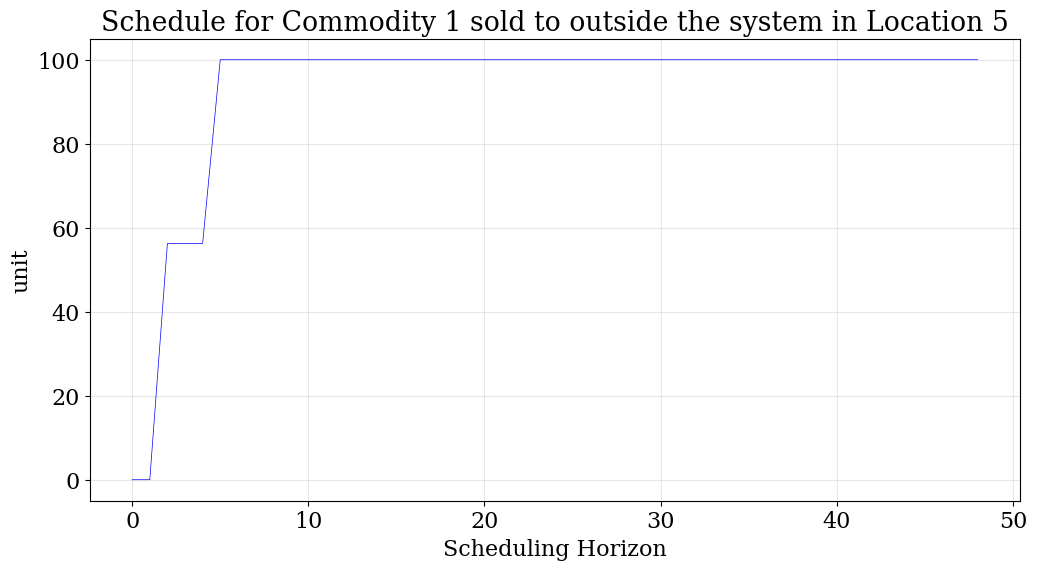

In [67]:
plot_results.schedule(results=result_cost, y_axis='S', component='com1_sold', location='loc5')

In [68]:
model_record[(0,4,6)].scales_demand.pprint()

scales_demand : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     3 :    Any :   42 : {(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 4, 6), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (0, 5, 6)}


In [69]:
print(*[(key,value) for key, value in result_cost.output['Cap_P'].items() if value], sep='\n')

(('loc1', 'com1_loc1_send', 0), 75.0)
(('loc1', 'com1_process', 0), 75.0)
(('loc1', 'procure com1', 0), 75.0)
(('loc2', 'com1_loc2_send', 0), 45.0)
(('loc2', 'com1_process', 0), 45.0)
(('loc2', 'com1_receive_loc1', 0), 45.0)
(('loc3', 'com1_loc3_send', 0), 30.0)
(('loc3', 'com1_process', 0), 30.0)
(('loc3', 'com1_receive_loc1', 0), 30.0)
(('loc4', 'com1_loc4_send', 0), 100.0)
(('loc4', 'com1_process', 0), 100.0)
(('loc4', 'com1_receive_loc2', 0), 45.0)
(('loc4', 'com1_receive_loc3', 0), 30.0)
(('loc4', 'com1_receive_loc6', 0), 50.0)
(('loc5', 'com1_process', 0), 100.0)
(('loc5', 'com1_receive_loc1', 0), 50.0)
(('loc5', 'com1_receive_loc2', 0), 30.0)
(('loc5', 'com1_receive_loc4', 0), 100.0)
(('loc5', 'com1_receive_loc6', 0), 6.25)
(('loc5', 'com1_receive_loc7', 0), 12.5)
(('loc5', 'com1_store', 0), 6.25)
(('loc5', 'com1_store_discharge', 0), 6.25)
(('loc5', 'sell com1', 0), 100.0)
(('loc6', 'com1_loc6_send', 0), 56.25)
(('loc6', 'com1_process', 0), 56.25)
(('loc6', 'com1_store', 0), 25

In [70]:
scenario_record[(0,0,0)].demand_penalty

{'loc1': {'com1_sold': 0},
 'loc2': {'com1_sold': 0},
 'loc3': {'com1_sold': 0},
 'loc4': {'com1_sold': 0},
 'loc5': {'com1_sold': 200},
 'loc6': {'com1_sold': 0},
 'loc7': {'com1_sold': 0}}

In [71]:
result_cost.output['S_location']

{('loc1', 'com1_sold', 0): 0.0,
 ('loc2', 'com1_sold', 0): 0.0,
 ('loc3', 'com1_sold', 0): 0.0,
 ('loc4', 'com1_sold', 0): 0.0,
 ('loc5', 'com1_sold', 0): 4568.75,
 ('loc6', 'com1_sold', 0): 0.0,
 ('loc7', 'com1_sold', 0): 0.0}

In [72]:
sum(value for key, value in result_cost.output['S'].items())

4568.75

In [83]:
t = (0,2,4)

In [84]:
model_record[t].objective_cost_w_demand_penalty.pprint()

objective_cost_w_demand_penalty : total cost with penalty for demand
    Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : Capex_network[0] + Capex_transport_network[0] + Vopex_network[0] + Fopex_network[0] + B_network[com1_pur,0] + Vopex_transport_network[0] + Fopex_transport_network[0] + Incidental_network[0] + Demand_penalty_cost_network[com1_sold,0] + Inv_cost_network[0]


In [85]:
model_record[t].constraint_demand_penalty_cost_network.pprint()

constraint_demand_penalty_cost_network : Total demand penalty cost for the network
    Size=1, Index=resources_demand*{0}, Active=True
    Key              : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                              : Upper : Active
    ('com1_sold', 0) :   0.0 : Demand_penalty_cost_network[com1_sold,0] - (Demand_penalty_cost_location[loc1,com1_sold,0] + Demand_penalty_cost_location[loc2,com1_sold,0] + Demand_penalty_cost_location[loc3,com1_sold,0] + Demand_penalty_cost_location[loc4,com1_sold,0] + Demand_penalty_cost_location[loc5,com1_sold,0] + Demand_penalty_cost_location[loc6,com1_sold,0] + Demand_penalty_cost_location[loc7,com1_sold,0]) :   0.0 :   Tr

In [86]:
model_record[t].Demand_penalty_cost_network.pprint()

Demand_penalty_cost_network : Total penalty cost for unmet demand from network
    Size=1, Index=resources_demand*scales_network
    Key              : Lower : Value : Upper : Fixed : Stale : Domain
    ('com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals


In [87]:
model_record[t].constraint_demand_penalty_cost_location.pprint()

constraint_demand_penalty_cost_location : Total demand penalty cost at a location
    Size=7, Index=locations*resources_demand*{0}, Active=True
    Key                      : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                             : Upper : Active
    ('loc1', 'com1_sold', 0) :   0.0 : Demand_penalty_cost_location[loc1,com1_sold,0] - (Demand_penalty_cost[loc1,com1_sold,0,2,4] + Demand_penalty_cost[loc1,com1_sold,0,2,5] + Demand_penalty_cost[loc1,com1_sold,0,2,6] + Demand_penalty_cost[loc1,com1_sold,0,3,0] + Demand_penalty_cost[loc1,com1_sold,0,3,1] + Demand_penalty_cost[loc1,com1_sold,0,3,2] + Demand_penalty_cost[loc1,com1_sold,0,3,3] + De

In [88]:
model_record[t].Demand_penalty_cost_location.pprint()

Demand_penalty_cost_location : Total penalty cost for unmet demand at a location
    Size=7, Index=locations*resources_demand*scales_network
    Key                      : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc1', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
    ('loc2', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
    ('loc3', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
    ('loc4', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
    ('loc5', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
    ('loc6', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
    ('loc7', 'com1_sold', 0) :     0 :   0.0 :  None : False :  True : NonNegativeReals
